In [1]:
import sys
sys.path.append('../quackd')

from distutils.command.bdist import show_formats
import qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute
from quantuminspire.qiskit import QI
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

from time import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import quackd.utils as u
u.set_qi_auth("../credentials/auth.json")

In [3]:
def create_calibration_matrix(qubits, qubit_list):
    """
    qubits [int]: number of qubits
    qubit_list [list] = list/array of qubits indexed into the backend
    """
    # create calibration circuits
    qr = QuantumRegister(qubits)
    meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='cal')
    # create calibration matrix by running calibration
    backend = QI.get_backend('QX single-node simulator') # replace 'with Starmon-5' later
    job = qiskit.execute(meas_calibs, backend=backend, shots=1024)
    cal_results = job.result()
    meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='cal')
    return meas_fitter

In [70]:
meas_fitter = create_calibration_matrix(1, [0])

In [71]:
def apply_measurement_error_mitigation(meas_fitter, raw_counts):
    """
    meas_fitter [qiskit ignis CompleteMeasFitter object]: calibration matrix fitter
    raw_counts [dict]: dictionary of bitstrings with respective counts
    """
    # apply measurement error mitigation via calibration matrix ####
    meas_filter = meas_fitter.filter
    mitigated_results = meas_filter.apply(raw_counts)
    return mitigated_results

In [4]:
basis_to_bit = {"Z" : "1", "X" : "0"}

In [5]:
def build_circuit(alice_string, bob_bases, qi_backend, n_shots=1024, meas_err_mitig=False):
    if len(alice_string) != len(bob_bases):
        raise IndexError(
            "Length of bit string and length of bases to measure in do not match."
        )
    else:
        length = len(alice_string)

    circuits = []
    known_indices = []
    final_bit_string = ""

    for index in range(length):
        qr = QuantumRegister(1)
        cr = ClassicalRegister(1)
        circuit = QuantumCircuit(qr, cr)
        bit = alice_string[index]
        basis = bob_bases[index]

        # Step 1: Initialize qubits according to Alice's bit string
        if bit == "0":  # if the bit is 0
            circuit.i(qr[0])  # we initialize the qubit in the |0> state
        elif bit == "1":  # if the bit is 1
            circuit.h(qr[0])  # we initialize the qubit in the |+> state

        # Step 2: Measure qubits in Bob's chosen bases
        if basis.upper() == "Z":  # if Bob picks the Z basis,
            circuit.i(qr[0])  # we stay in the Z basis
        elif basis.upper() == "X":  # if Bob picks the X basis,
            circuit.h(qr[0])  # we apply a Hadamard gate so that the measurement will be in the Z basis
        circuit.measure(qr, cr)

        # Step 3: run the circuits on the Quantum Inspire backend and compile the results
        qi_job = execute(circuit, backend=qi_backend, shots=n_shots)
        qi_result = qi_job.result()
        histogram = qi_result.get_counts(circuit)
        if meas_err_mitig:
            histogram = apply_measurement_error_mitigation(meas_fitter, histogram)

        # print(histogram)

        # num_0 counts eigvl = 1
        # num_1 counts eigvl = -1
        num_0, num_1 = 0, 0 

        if "0" in histogram.keys():
            num_0 = histogram["0"]
        if "1" in histogram.keys():
            num_1 = histogram["1"]

        # print(f"num_0:\t{num_0}\nnum_1:\t{num_1}\n")

        if num_0 >= num_1:
            # we take majority rule, state collapses to +1 eigenvalue of the measurement basis
            # or equal amount of 0 and 1 measurement results, result is indeterminate
            bit = "n"  # bit is indeterminate
        else:
            # we take majority rule, state collapses to -1 eigenvalue of the measurement basis
            bit = basis_to_bit[basis.upper()]
            # this index with eigvl = -1 gives a determined bit that we append to known_indices
            known_indices.append(index)
            
        final_bit_string += bit
        circuits.append(circuit)

    return final_bit_string, known_indices, circuits

In [8]:
def get_secure_key_alice(alice_string, known_indices):
    secure_key = ""
    for index in known_indices:
        bit = alice_string[index]
        secure_key += bit
    return secure_key

def get_secure_key_bob(final_bit_string, known_indices):
    secure_key = ""
    for index in known_indices:
        bit = final_bit_string[index]
        secure_key += bit
    return secure_key

In [31]:
def build_circuit_5(alice_string, bob_bases, qi_backend, n_shots=1024):#, meas_err_mitig=False):
    if len(alice_string) != len(bob_bases):
        raise IndexError(
            "Length of bit string and length of bases to measure in do not match."
        )
    else:
        length = len(alice_string)

    circuits = []
    known_indices = []
    final_bit_string = ""

    for index in range(0, length, 5):
        reg_len = 5
        if length - index < 5:
            reg_len = length - index
        
        qr = QuantumRegister(reg_len)
        circuit = QuantumCircuit(qr)
        bits = alice_string[index : index + reg_len]
        bases = bob_bases[index : index + reg_len]
        print("bits:", bits)
        print("bases:", bases)

        # Step 1: Initialize qubits according to Alice's bit string
        for r in range(reg_len):
            bit = bits[r]
            
            if bit == "0":  # if the bit is 0
                circuit.i(qr[r])  # we initialize the qubit in the |0> state
            elif bit == "1":  # if the bit is 1
                circuit.h(qr[r])  # we initialize the qubit in the |+> state

        # Step 2: Measure qubits in Bob's chosen bases
        for r in range(reg_len):
            basis = bases[r]
            
            if basis.upper() == "Z":  # if Bob picks the Z basis,
                circuit.i(qr[r])  # we stay in the Z basis
            elif basis.upper() == "X":  # if Bob picks the X basis,
                circuit.h(qr[r])  # we apply a Hadamard gate so that the measurement will be in the Z basis
            
        circuit.measure_all()
        circuits.append(circuit)
        # Step 3: run the circuits on the Quantum Inspire backend and compile the results
    qi_job = execute(circuits, backend=qi_backend, shots=n_shots)
    qi_result = qi_job.result()
    num_arrays_finished = 0
    for index in range(0, length, 5):
        reg_len = 5
        if length - index < 5:
            reg_len = length - index
        
        bases = bob_bases[index : index + reg_len]
        bits = alice_string[index : index + reg_len]
        circuit = circuits[num_arrays_finished]
        histogram = qi_result.get_counts(circuit)
#         if meas_err_mitig:
#             histogram = apply_measurement_error_mitigation(meas_fitter, histogram)

        print(histogram)
    
#         most_freq_result = max(histogram, key = histogram.get)
#         most_freq_result = most_freq_result[::-1]
        
#         print(most_freq_result)
        
        for r in range(reg_len):
            
            num_0, num_1 = 0, 0 
            
            for key in histogram.keys():
                if key[reg_len - 1 - r] == "0":
                    num_0 += histogram[key]
                elif key[reg_len - 1 - r] == "1":
                    num_1 += histogram[key]
            

            if num_0 >= num_1:
                # state collapses to +1 eigenvalue of the measurement basis
                bit = "n"  # bit is indeterminate
            else:
                # state collapses to -1 eigenvalue of the measurement basis
                basis = bases[r]
                bit = basis_to_bit[basis.upper()]
                # this index with eigvl = -1 gives a determined bit that we append to known_indices
                known_indices.append(index + r)

            final_bit_string += bit
        num_arrays_finished += 1

    return final_bit_string, known_indices, circuits

In [ ]:
# QI.get_backend("Starmon-5")
# QI.get_backend("QX single-node simulator")
N = 40

initial_bit_string = np.random.choice(["0", "1"], N)
bases = np.random.choice(["X", "Z"], N)

print(" ".join(initial_bit_string))
print(" ".join(bases))

start = time()

final_bit_string, known_indices, circuits = build_circuit(initial_bit_string, bases, QI.get_backend("QX single-node simulator"), n_shots=16, meas_err_mitig=True)

finish = time()

print(" ".join(final_bit_string))

print(f"\nElapsed Time: {np.round(finish - start, 2)} seconds")

1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 0 1 0 0 0 0 1 0
X Z X X Z Z Z Z X X X Z X Z Z Z X Z X Z Z Z Z Z Z Z X Z X X X X X X Z Z X X X X


In [32]:
# QI.get_backend("Starmon-5")
# QI.get_backend("QX single-node simulator")
N_5 = 20

initial_bit_string_5 = np.random.choice(["0", "1"], N_5)
bases_5 = np.random.choice(["X", "Z"], N_5)

print(" ".join(initial_bit_string_5))
print(" ".join(bases_5))

start_5 = time()

final_bit_string_5, known_indices_5, circuits_5 = build_circuit_5(initial_bit_string_5, bases_5, QI.get_backend("QX single-node simulator"), n_shots=100)

finish_5 = time()

print(" ".join(initial_bit_string_5))
print(" ".join(bases_5))
print(" ".join(final_bit_string_5))

print(f"\nElapsed Time: {np.round(finish_5 - start_5, 2)} seconds")

0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 1 1 0
X Z X Z Z X X X Z Z Z X Z Z Z X Z Z X Z
bits: ['0' '0' '0' '0' '1']
bases: ['X' 'Z' 'X' 'Z' 'Z']
bits: ['0' '0' '1' '0' '0']
bases: ['X' 'X' 'X' 'Z' 'Z']
bits: ['1' '1' '1' '1' '1']
bases: ['Z' 'X' 'Z' 'Z' 'Z']
bits: ['0' '0' '1' '1' '0']
bases: ['X' 'Z' 'Z' 'X' 'Z']
{'00000': 5, '00001': 7, '00100': 11, '00101': 19, '10000': 16, '10001': 12, '10100': 13, '10101': 17}
{'00000': 28, '00001': 24, '00010': 23, '00011': 25}
{'00000': 7, '00001': 4, '00100': 7, '00101': 8, '01000': 9, '01001': 2, '01100': 4, '01101': 5, '10000': 4, '10001': 4, '10100': 12, '10101': 9, '11000': 7, '11001': 6, '11100': 7, '11101': 5}
{'00000': 20, '00001': 25, '00100': 36, '00101': 19}
0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 1 1 0
X Z X Z Z X X X Z Z Z X Z Z Z X Z Z X Z
0 n 0 n 1 0 0 n n n 1 n 1 1 1 0 n 1 n n

Elapsed Time: 18.76 seconds


In [33]:
secure_key_alice = get_secure_key_alice(initial_bit_string_5, known_indices_5)
secure_key_bob = get_secure_key_bob(final_bit_string_5, known_indices_5)
print(secure_key_alice)
print(secure_key_bob)

00100111101
00100111101


In [208]:
sent_digits = list(secure_key_alice)
corrected_digits = list(secure_key_bob)

In [209]:
"""
block size k(i, Q) as a function of the iteration number i and the quantum bit error rate Q:
k(1, Q) = 0.73 / Q
k(i + 1, Q) = 2 * k(i, Q)
"""
N = len(sent_digits)
Q = 0.01 # np.sum(np.array(sent_digits) != np.array(corrected_digits)) / N

In [210]:
#################### ------------ ####################
#################### BINARY SPLIT ####################
#################### ------------ ####################

# count parity
def parity(block):
    # return np.count_nonzero(block == "1") % 2
    return block.count("1") % 2


# binary split and correct odd parities
def bin_split(si = 0, fi = N, parity_cnt = 1):
    if fi < N:
        block_a = sent_digits[si : fi]
        block_b = corrected_digits[si : fi]
    else:
        block_a = sent_digits[si : N - 1] + [sent_digits[N - 1]]
        block_b = corrected_digits[si : N - 1] + [corrected_digits[N - 1]]

    # print(parity_cnt)
    # print(block_a)
    # print(block_b)
    if parity(block_a) != parity(block_b):
        if fi - si == 1:
            # "0" -> "1" and "1" -> "0"
            corrected_digits[si] = str(1 - int(corrected_digits[si]))
            return parity_cnt
        else:
            # right block bigger
            mid = si + (fi - si) // 2
            return bin_split(si, mid, parity_cnt + 1) + bin_split(mid, fi, parity_cnt + 1)
    else:
        return 1


In [211]:
#################### ------- ####################
#################### SHUFFLE ####################
#################### ------- ####################
import random


def getperm(iter_n, block):
    random.seed(iter_n)
    perm = list(range(len(block)))
    random.shuffle(perm)
    random.seed()  # optional, in order to not impact other code based on random
    return perm


def shuffle(iter_n, block):
    perm = getperm(iter_n, block)
    block[:] = [block[j] for j in perm]


def unshuffle(iter_n, block):
    perm = getperm(iter_n, block)
    res = [None] * len(block)
    for i, j in enumerate(perm):
        res[j] = block[i]
    block[:] = res

In [212]:
#################### ------- ####################
#################### CASCADE ####################
#################### ------- ####################
parity_checks = [0]
block_sizes = []

# shuffle, binary split blocks, unshuffle
def cascade(iter_n):

    k = min(int(0.73 / Q * 2 ** iter_n), N)
    print("Block Size:", k)
    block_sizes.append(k)

    shuffle(iter_n, sent_digits)
    shuffle(iter_n, corrected_digits)

    # binary split blocks and count parity checks
    iter_n_parity_checks = 0
    for i in range(0, N, k):
        if i + k <= N:
            iter_n_parity_checks += bin_split(i, i + k)
        else:
            iter_n_parity_checks += bin_split(i, N)

    # print("Parity Checks:", iter_n_parity_checks)
    parity_checks.append(parity_checks[-1] + iter_n_parity_checks)
    # print("Cumulative Parity Checks:", parity_checks[-1])

    unshuffle(iter_n, sent_digits)
    unshuffle(iter_n, corrected_digits)

In [213]:
errors = [Q]
for c in range(5):
    print()
    print("----------Testing Cascade " + str(c) + "----------")
    cascade(c)
    # print("S:", sent_digits)
    # print("C:", corrected_digits)
    error = np.mean(np.array(sent_digits) != np.array(corrected_digits))
    print("Error Rate:", error)
    print("Parity Checks:", parity_checks[-1])
    errors.append(error)

print("\n----------Final Results----------")
print("Final Block Size:", block_sizes[-1])
print("Final Error Rate:", errors[-1])
print("Final Parity Checks:", parity_checks[-1])
print("Final Parity Check Rate:", parity_checks[-1] / N)


----------Testing Cascade 0----------
Block Size: 12
Error Rate: 0.0
Parity Checks: 1

----------Testing Cascade 1----------
Block Size: 12
Error Rate: 0.0
Parity Checks: 2

----------Testing Cascade 2----------
Block Size: 12
Error Rate: 0.0
Parity Checks: 3

----------Testing Cascade 3----------
Block Size: 12
Error Rate: 0.0
Parity Checks: 4

----------Testing Cascade 4----------
Block Size: 12
Error Rate: 0.0
Parity Checks: 5

----------Final Results----------
Final Block Size: 12
Final Error Rate: 0.0
Final Parity Checks: 5
Final Parity Check Rate: 0.4166666666666667


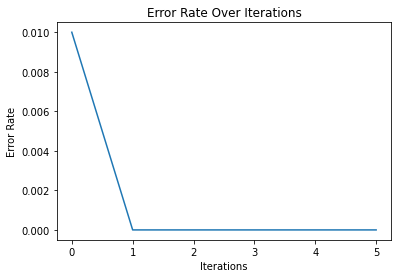

In [214]:
# Error Rate plot
plt.title("Error Rate Over Iterations")
plt.xlabel("Iterations")
plt.ylabel("Error Rate")
plt.plot(np.arange(len(errors)), errors)
plt.show()

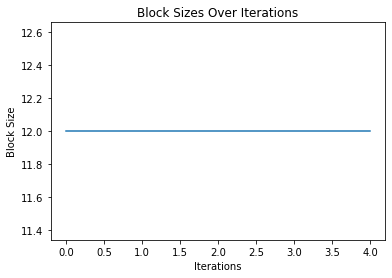

In [215]:
# Block Size plot
plt.title("Block Sizes Over Iterations")
plt.xlabel("Iterations")
plt.ylabel("Block Size")
plt.plot(np.arange(len(block_sizes)), block_sizes)
plt.show()

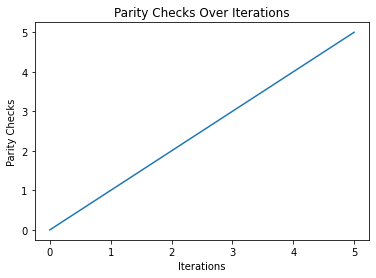

In [216]:
# Parity Check plot
plt.title("Parity Checks Over Iterations")
plt.xlabel("Iterations")
plt.ylabel("Parity Checks")
plt.plot(np.arange(len(parity_checks)), parity_checks)
plt.show()